<a href="https://colab.research.google.com/github/adityapattar3322/Signature-Forgery-Detection/blob/main/Signature_Forgery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import numpy as np

# For feature extraction
from skimage.feature import hog, local_binary_pattern

# For machine learning models and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def load_images(folder_path):
    """Loads images from a folder and preprocesses them."""
    images = []
    for filename in os.listdir(folder_path):
        # Read the image in grayscale
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Resize to a standard size
            img = cv2.resize(img, (128, 128))
            # Binarize the image to make the signature white and background black
            _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            images.append(img)
    return images

# Define the paths to your dataset
# Make sure to change these paths to match your folder structure
genuine_folder = '/content/sample_data/Signatures/Genuine'
forged_folder = '/content/sample_data/Signatures/Forged'

# Load the images
genuine_images = load_images(genuine_folder)
forged_images = load_images(forged_folder)

# Create numerical labels: 1 for Genuine, 0 for Forged
genuine_labels = [1] * len(genuine_images)
forged_labels = [0] * len(forged_images)

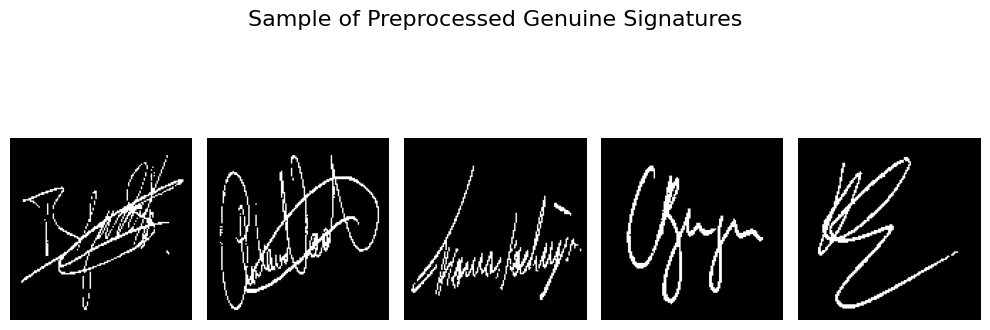

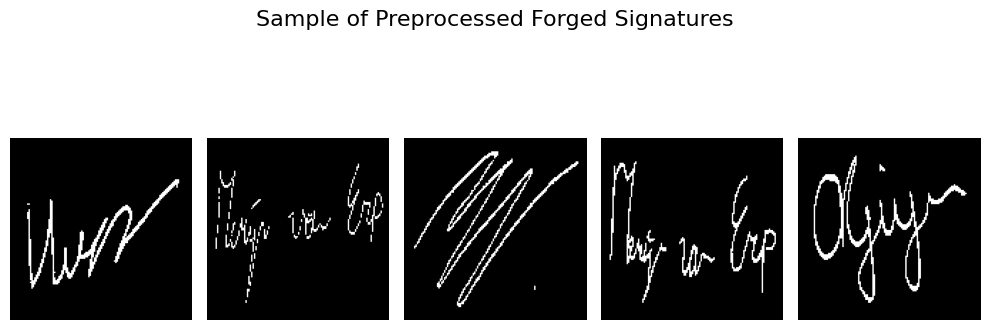

In [ ]:
def visualize_signatures(images, title):
    """Displays a sample of preprocessed signature images."""
    plt.figure(figsize=(10, 4))
    plt.suptitle(title, fontsize=16)

    # Get 5 random indices to display, or fewer if the dataset is small
    num_samples = min(len(images), 5)
    indices = np.random.choice(len(images), size=num_samples, replace=False)

    for i, index in enumerate(indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[index], cmap='gray')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for the main title
    plt.show()

# Visualize a sample of genuine signatures
visualize_signatures(genuine_images, "Sample of Preprocessed Genuine Signatures")

# Visualize a sample of forged signatures
visualize_signatures(forged_images, "Sample of Preprocessed Forged Signatures")

In [ ]:
def extract_features(images):
    """Extracts a combination of HOG and LBP features from a list of images."""
    features_list = []
    for image in images:
        # 1. HOG features
        hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')

        # 2. LBP features
        lbp = local_binary_pattern(image, P=24, R=8, method="uniform")
        (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))

        # Normalize the LBP histogram
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6) # Add epsilon to avoid division by zero

        # 3. Combine HOG and LBP features into a single feature vector
        combined_features = np.hstack([hog_features, lbp_hist])
        features_list.append(combined_features)

    return np.array(features_list)

# First, combine the images and labels into single lists
all_images = np.array(genuine_images + forged_images)
all_labels = np.array(genuine_labels + forged_labels)

# Now, extract features from all images
all_features = extract_features(all_images)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( all_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Accuracy: 82.57%

Classification Report:
              precision    recall  f1-score   support

      Forged       0.79      0.89      0.83        54
     Genuine       0.88      0.76      0.82        55

    accuracy                           0.83       109
   macro avg       0.83      0.83      0.83       109
weighted avg       0.83      0.83      0.83       109



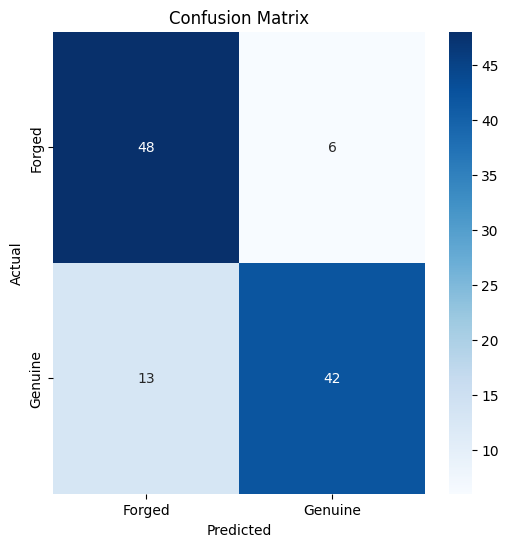

In [ ]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Forged', 'Genuine']))

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Forged', 'Genuine'],
            yticklabels=['Forged', 'Genuine'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("--- Training SVM with GridSearchCV ---")
# Define the parameter grid to search
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']}

# Create and fit the GridSearchCV object
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=0, cv=3)
grid.fit(X_train, y_train)

# Get the best model found by the grid search
best_svm = grid.best_estimator_
print(f"Best SVM Parameters: {grid.best_params_}")

# Evaluate the best SVM model
y_pred_svm = best_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nTuned SVM Accuracy: {accuracy_svm * 100:.2f}%")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Forged', 'Genuine']))

--- Training SVM with GridSearchCV ---
Best SVM Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Tuned SVM Accuracy: 85.32%

SVM Classification Report:
              precision    recall  f1-score   support

      Forged       0.80      0.94      0.86        54
     Genuine       0.93      0.76      0.84        55

    accuracy                           0.85       109
   macro avg       0.87      0.85      0.85       109
weighted avg       0.87      0.85      0.85       109



In [ ]:
print("\n--- Training Random Forest Classifier ---")
# Initialize and train the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Forged', 'Genuine']))


--- Training Random Forest Classifier ---
Random Forest Accuracy: 85.32%

Random Forest Classification Report:
              precision    recall  f1-score   support

      Forged       0.81      0.93      0.86        54
     Genuine       0.91      0.78      0.84        55

    accuracy                           0.85       109
   macro avg       0.86      0.85      0.85       109
weighted avg       0.86      0.85      0.85       109




Displaying Confusion Matrix for the best model: Random Forest


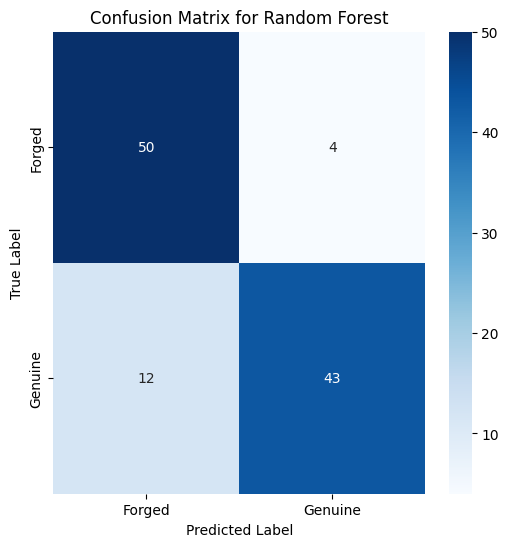

In [ ]:
# Choose the best model's predictions for the confusion matrix
if accuracy_svm > accuracy_rf:
    best_preds = y_pred_svm
    model_name = "Tuned SVM"
    print(f"\nDisplaying Confusion Matrix for the best model: {model_name}")
else:
    best_preds = y_pred_rf
    model_name = "Random Forest"
    print(f"\nDisplaying Confusion Matrix for the best model: {model_name}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Forged', 'Genuine'],
            yticklabels=['Forged', 'Genuine'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()